# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

from math import ceil

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Initial parameters definition

In [2]:
N = 10
dt = 1

rho = 1000
g = pp.GRAVITY_ACCELERATION

T = 10

output_directory = 'output_time'

Mass generation term and initial pressure

In [3]:
def f(x, t): 
    if x[1] > 1-1/N and x[0] >0.4 and x[0] < 0.6:# and t < 2:
        return 10
    return 0

def initial_pressure_func(x): 
    return (1-x[1])

We create now the grid, since we will use a Raviart-Thomas approximation for ${q}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 1d and 3d. PyGeoN works with mixed-dimensional grids, so we need to convert the grid.

In [4]:
subdomain = pp.StructuredTriangleGrid([N] * 2, [1] * 2)
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

/opt/conda/lib/python3.11/site-packages/porepy/viz/plot_grid.py:197: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


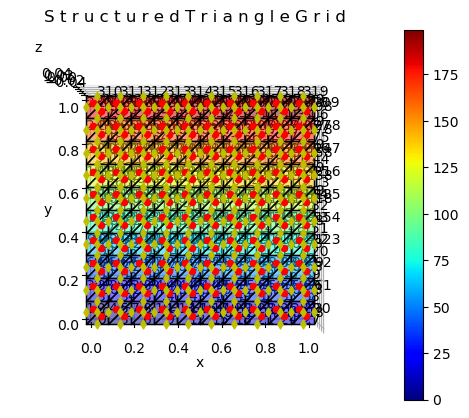

In [5]:
pp.plot_grid(subdomain, cell_value=np.arange(subdomain.num_cells), info='cf', alpha=0.5, figsize=(15,12))

With the following code we set the data, in particular the permeability tensor and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [6]:
key = "flow"

bc_value = []
bc_essential = []

gravity = []
initial_pressure = []
tmp_discrete_f = []

RT0 = pg.RT0(key)
P0 = pg.PwConstants(key)

def g_func(x): return np.array([0, -1, -1])

def p_bc(x): return x[1]

In [7]:
for subdomain, data in mdg.subdomains(return_data=True):
    gravity.append(          RT0.assemble_mass_matrix(subdomain) @ RT0.interpolate(subdomain, g_func) )
    initial_pressure.append(  P0.interpolate(subdomain, initial_pressure_func) )
    tmp_discrete_f.append( lambda t: P0.interpolate(subdomain, lambda x: f(x,t)) )

    # permeability tensor
    perm = pp.SecondOrderTensor(np.ones(subdomain.num_cells))
    parameters = {
        "second_order_tensor": perm,
    }
    pp.initialize_data(subdomain, data, key, parameters)
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    left_right = np.logical_or(subdomain.face_centers[0, :] == 0,  subdomain.face_centers[0, :] == 1)

    bottom = subdomain.face_centers[1, :] == 0
    top    = subdomain.face_centers[1, :] == 1
    
    def p_bc(x): return 1

    bc_value.append(- RT0.assemble_nat_bc(subdomain, p_bc, bottom))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((np.logical_or(left_right, top), essential_pressure_dofs)))

In [8]:
discrete_f = lambda t: np.hstack( list( (tmp_discrete_f[i](t)) for i in range(len(tmp_discrete_f)) ) )

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation at every timestep is given as
$$
\left(
\begin{array}{cc} 
M_K &     B^\top\\
-\Delta t B  & M_p
\end{array}
\right)
\left(
\begin{array}{c} 
q^{n+1}\\ 
p^{n+1}
\end{array}
\right)
=\left(
\begin{array}{c} 
p_{\partial} + M_p g\\ 
M_p p^n + \Delta t M_p f^{n+1}
\end{array}
\right)
$$<br>
where $p_{\partial}$ is the vector associated to the pressure boundary contions, $(\cdot)^n$ is a generic variable at the n-th time instant. We can now construct the initial building blocks of the monolithic matrix:

In [9]:
# construct the local matrices
mass_q = pg.face_mass(mdg)
mass_p = pg.cell_mass(mdg)

B = - mass_p * pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = B.shape

Here, a simple function to construct the right hand side (rhs) at every time instant is defined

In [10]:
# assemble the right-hand side
fixed_rhs = np.zeros(dof_p + dof_q)

fixed_rhs[:dof_q] += np.hstack(gravity)
fixed_rhs[:dof_q] += np.hstack(bc_value)


def assemple_rhs(previous_solution, time) -> np.array:
    rhs = fixed_rhs.copy()
    rhs[-dof_p:] += (mass_p @ previous_solution[-dof_p:] + dt * mass_p @ discrete_f(time))

    print( mass_p @ previous_solution[-dof_p:], dt * mass_p @ discrete_f(time) )

    return rhs

Here, we prepare a simple function to export the solution at every instant

In [11]:
proj_q = RT0.eval_at_cell_centers(subdomain)
proj_p =  P0.eval_at_cell_centers(subdomain)

In [12]:
def save_step(saver, current_sol, step):
    ins = list()

    ins.append((subdomain, "cell_q", ( proj_q @ current_sol[:dof_q] ).reshape((3, -1), order="F")))
    ins.append((subdomain, "cell_p", proj_p @ current_sol[-dof_p:]))

    saver.write_vtu(ins, time_step=step)

In [13]:
# assemble initial solution
initial_solution = np.zeros(dof_p + dof_q)
initial_solution[-dof_p:] += np.hstack(initial_pressure)

In [14]:
# solve the problem

sol = [initial_solution]

t = 0

if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

save = pp.Exporter(mdg, "sol", folder_name=output_directory)
save_step(save, sol[-1], 0)

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (flux boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom. Once the problem is solved, we extract the two solutions $q$ and $p$.

In [15]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    spp = sps.bmat([[mass_q,       B.T], 
                    [ -dt*B,    mass_p]], format="csc")
    
    ls = pg.LinearSystem(spp, assemple_rhs(sol[-1], step*dt))
    ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_p))

    sol.append( ls.solve() )

    save_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt) + 1)) * dt)

[0.96666667 0.93333333 0.96666667 0.93333333 0.96666667 0.93333333
 0.96666667 0.93333333 0.96666667 0.93333333 0.96666667 0.93333333
 0.96666667 0.93333333 0.96666667 0.93333333 0.96666667 0.93333333
 0.96666667 0.93333333 0.86666667 0.83333333 0.86666667 0.83333333
 0.86666667 0.83333333 0.86666667 0.83333333 0.86666667 0.83333333
 0.86666667 0.83333333 0.86666667 0.83333333 0.86666667 0.83333333
 0.86666667 0.83333333 0.86666667 0.83333333 0.76666667 0.73333333
 0.76666667 0.73333333 0.76666667 0.73333333 0.76666667 0.73333333
 0.76666667 0.73333333 0.76666667 0.73333333 0.76666667 0.73333333
 0.76666667 0.73333333 0.76666667 0.73333333 0.76666667 0.73333333
 0.66666667 0.63333333 0.66666667 0.63333333 0.66666667 0.63333333
 0.66666667 0.63333333 0.66666667 0.63333333 0.66666667 0.63333333
 0.66666667 0.63333333 0.66666667 0.63333333 0.66666667 0.63333333
 0.66666667 0.63333333 0.56666667 0.53333333 0.56666667 0.53333333
 0.56666667 0.53333333 0.56666667 0.53333333 0.56666667 0.5333